In [1]:
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import matplotlib.cm as mpl_cm
from brian2.only import *

%load_ext autoreload
%autoreload 1

%aimport numpy_
%aimport spatial
%aimport model
%aimport inputs
%aimport util
%aimport spike_utils
%aimport readout

# for the IDE:
import numpy_ as np
import spatial, model, inputs, readout

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes

In [2]:
rng = np.random.default_rng()
set_device('cpp_standalone')
prefs.devices.cpp_standalone.openmp_threads = mp.cpu_count() - 2

In [3]:
N = 1000
inhibitory_ratio = .2

params = {
    # Simulation
    'dt': 1*ms,
    
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    'voltage_init': 'v_rest',
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    'weight_distribution': 'singular',
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': 1,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 50,
    'w_exc_mean': 1,

    # Stimulus
    'N_stimuli': 5,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 5,
    'sequence_count': 20,
    'fully_random_msc': True,
    'ISI': 500*ms,
}

In [4]:
def plot_events(W, params, full_results, neuron_idx, figsize=None):
    sources = np.flatnonzero(W[:, neuron_idx] > 0)
    weights = W[sources, neuron_idx]
    keys = ('std', 'dev', 'msc')
    
    target_hists, source_hists, source_xrs = [], [], []
    for key in keys:
        target_hists.append(full_results[key]['spike_hist'][neuron_idx])
        source_hists.append(full_results[key]['spike_hist'][sources])
        source_xrs.append(full_results[key]['xr_sum'][sources])
    
    target_hists = np.asarray(target_hists)  # key, t
    source_hists = np.asarray(source_hists)  # key, sources, t
    source_xrs = np.asarray(source_xrs)  # key, sources
    tmax = max(
        np.flatnonzero(source_hists.sum(axis=(0,1)) > 0)[-1],
        np.flatnonzero(target_hists.sum(axis=0) > 0)[-1]
    )
    x = np.arange(tmax+1)*params['dt'] / msecond
    y = np.arange(len(sources)+1)

    weight_signs = np.ones(len(sources))
    weight_signs[sources >= params['N_exc']] = -1
    maxw = weights.max()
    weighted_total = np.sum(source_xrs * weights * weight_signs, axis=0)
    order = np.argsort(weighted_total)

    fig, axs = plt.subplots(len(keys), figsize=figsize)
    for i, (ax, key) in enumerate(zip(axs, keys)):
        m = ax.pcolormesh(x, y, source_hists[i, order, :tmax] * weight_signs[order, None], vmin=-1, vmax=1, cmap='seismic_r', shading='flat')
        ax.axhline(y[-1], color='k', lw=1)
        ax.pcolormesh(x, np.asarray([y[-1], y[-1]+5]), target_hists[i, None, :tmax], vmin=0, vmax=1, cmap='Greys', shading='flat')
        ax.set_ylabel(key)

        ax3 = ax.twiny()
        ax3.plot(weights[order] * full_results[key]['pulse_onset_xr'][:, sources[order]].mean(0), np.arange(len(sources)), c='magenta', lw=1)
        ax3.plot(weights[order], np.arange(len(sources)), c='purple', lw=1)
        ax3.plot(full_results[key]['pulse_onset_th_adapt'][:, sources[order]].mean(0)/mV, np.arange(len(sources)), c='green', lw=1)
        ax3.plot(full_results[key]['pulse_onset_th_adapt'][:, neuron_idx].mean()/mV, y[-1]+2.5, 'g*')
        ax3.set_xlim([5*maxw, 0])
        if i == 0:
            ax3.set_xticks([maxw, maxw/2, 0])
            ax3.set_xlabel('|w| (purple); STD at t=0 (magenta); adaptation at t=0 (green, mV)')
        else:
            ax3.set_xticks([])
    plt.colorbar(m, location='right', ax=axs, label='signed p(spike)')

In [5]:
def get_onset_ordering(full_results, limit=None):
    hist_sum = np.sum([full_results[key]['spike_hist'] for key in ('std', 'dev', 'msc')], axis=0)
    first_index = np.sum(np.cumsum(hist_sum, axis=1) == 0, axis=1)
    safe_first_index = first_index.copy()
    safe_first_index[first_index >= hist_sum.shape[1]] = 0
    first_intensity = hist_sum[np.arange(hist_sum.shape[0]), safe_first_index]
    onset_sort = np.lexsort((-first_intensity, first_index))
    order = onset_sort[:limit]
    tmax = np.flatnonzero(hist_sum[order].sum(axis=0))[-1]
    return order, tmax

In [6]:
def time(ticks):
    return ticks*params['dt'] / msecond

In [7]:
def plot_population_spikehist(params, full_results, earliest=1000, figsize=(10,25), grid=False, return_selection=False):
    selection, tmax = get_onset_ordering(full_results, earliest)

    x = time(np.arange(tmax+1))
    y = np.arange(earliest+1)
    signs = np.ones((params['N'], 1))
    signs[params['N_exc']:] = -1
    signs = signs[selection]
    
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    for ax, key in zip(axs, ('std', 'dev', 'msc')):
        hist = full_results[key]['spike_hist'][selection, :tmax]
        m = ax.pcolormesh(x, y, hist*signs, vmin=-1, vmax=1, cmap='seismic_r', shading='flat')

        if grid:
            ax.grid()
        ax.set_title(key)
        ax.set_xlabel('Time after pulse onset (ms)')
    axs[0].set_ylabel('Neurons, sorted by activity onset')
    plt.colorbar(m, location='bottom', ax=axs, label='signed p(spike)', aspect=40)

    if return_selection:
        return selection

In [8]:
def plot_population_time_contrast(params, full_results, cond1, cond2, measure, divisor=1, limit=None, figsize=(10,25), grid=False, vmax=None):
    shape = full_results[cond1][measure].shape
    data1 = full_results[cond1][measure]
    data2 = full_results[cond2][measure]
    if len(shape) == 3:
        assert shape[0] == params['N']
        assert shape[2] == int(params['ISI']/params['dt'] +.5)
        data1, data2 = data1.mean(1), data2.mean(1)
    elif len(shape) == 2:
        if shape[0] == params['N']:
            assert shape[1] == int(params['ISI']/params['dt'] +.5)
        elif shape[1] == params['N']:
            assert shape[0] == int(params['ISI']/params['dt'] +.5)
            data1, data2 = data1.T, data2.T

    order, tmax = get_onset_ordering(full_results, limit)
    x = time(np.arange(tmax+1))
    y = np.arange(params['N']+1)
    data = data1 - data2
    if vmax is None:
        vmax = np.max(np.abs(data/divisor))
    
    plt.figure(figsize=figsize)
    m = plt.pcolormesh(x, y, data[order, :tmax]/divisor, vmin=-vmax, vmax=vmax, cmap='PiYG', shading='flat')
    if grid:
        plt.grid()
    plt.colorbar(m, location='bottom', aspect=40, fraction=1/figsize[1], pad=.5/figsize[1])
    plt.tight_layout(pad=0.)

In [9]:
def scatter_nspikes(params, std, dev, msc, target, normalise='subtractive'):
    s = std['pulsed_nspikes'][std['Seq']==target].mean(0)
    d = dev['pulsed_nspikes'][dev['Seq']==target].mean(0)
    c = msc['pulsed_nspikes'][msc['Seq']==target].mean(0)
    if 'mult' in normalise:
        s[s==0] = np.inf
        mask = s>0
        d=d[mask]/s[mask]
        c=c[mask]/s[mask]
        plt.loglog()
        normstr = '/std'
        colors = np.where(np.arange(params['N']) < params['N_exc'], np.asarray(['b']), np.asarray(['r']))
        plt.axhline(1, c='k', ls='--', lw=1)
        plt.axvline(1, c='k', ls='--', lw=1)
    elif 'sub' in normalise:
        c = c-s
        d = d-s
        normstr = '-std'
        colors = np.where(np.arange(params['N']) < params['N_exc'], np.asarray(['b']), np.asarray(['r']))
        plt.axhline(0, c='k', ls='--', lw=1)
        plt.axvline(0, c='k', ls='--', lw=1)
    else:
        normstr = ''
        colors = np.where(d > s, np.asarray(['green']), np.asarray(['purple']))
    plt.scatter(c, d, c=colors)
    xlim, ylim = plt.xlim(), plt.ylim()
    lo, hi = min(np.min(c), np.min(d)), max(np.max(c), np.max(d))
    plt.plot([lo, hi], [lo, hi], 'k--', lw=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.ylabel(f'dev{normstr}')
    plt.xlabel(f'msc{normstr}')

In [10]:
def scatter_IO(params, all_results, target, cond1, cond2):
    fig, axs = plt.subplots(2, 4, figsize=(20,10))
    axs = axs.flatten()
    plt.suptitle(f'{target}, {cond1} - {cond2}')
    x = all_results[target][cond1]['nspikes'] - all_results[target][cond2]['nspikes']
    colors = np.where(np.arange(params['N']) < params['N_exc'], np.asarray(['b']), np.asarray(['r']))
    for ax, key in zip(axs, ('inputs_inh', 'inputs_exc', 'depression_factor')):
        y = all_results[target][cond1][key] - all_results[target][cond2][key]
        ax.scatter(x, y, c=colors)
        ax.set_xlabel('$\\Delta$ Output spikes per pulse')
        ax.set_ylabel(f'$\\Delta$ {key}')
        nan = np.isnan(x+y)
        ax.set_title(r'$r^2 = $' + f'{np.corrcoef(x[~nan], y[~nan])[0,1]**2:.2f}')

    exc = np.arange(params['N_exc'])
    y1, y2 = all_results[target][cond1]['pulse_onset_th_adapt'][:, exc], all_results[target][cond2]['pulse_onset_th_adapt'][:, exc]
    y = y1.mean(0) - y2.mean(0)
    axs[3].scatter(x[exc], y/mV, c=colors[exc])
    axs[3].set_xlabel('$\\Delta$ Output spikes per pulse')
    axs[3].set_ylabel(f'$\\Delta$ threshold adaptation (mV)')
    nan = np.isnan(x[exc])
    axs[3].set_title(r'$r^2 = $' + f'{np.corrcoef(x[exc][~nan], y[~nan])[0,1]**2:.2f}')
    
    y = (all_results[target][cond1]['inputs_exc']*all_results[target][cond1]['depression_factor']
        - all_results[target][cond2]['inputs_exc']*all_results[target][cond2]['depression_factor'])
    axs[4].scatter(x, y, c=colors)
    axs[4].set_xlabel('$\\Delta$ Output spikes per pulse')
    axs[4].set_ylabel(f'$\\Delta$ total excitatory input')
    nan = np.isnan(x+y)
    axs[4].set_title(r'$r^2 = $' + f'{np.corrcoef(x[~nan], y[~nan])[0,1]**2:.2f}')

    input_1 = all_results[target][cond1]['inputs_exc']*all_results[target][cond1]['depression_factor'] - all_results[target][cond1]['inputs_inh']
    input_2 = all_results[target][cond2]['inputs_exc']*all_results[target][cond2]['depression_factor'] - all_results[target][cond2]['inputs_inh']
    y = input_1 - input_2
    axs[5].scatter(x, y, c=colors)
    axs[5].set_xlabel('$\\Delta$ Output spikes per pulse')
    axs[5].set_ylabel(f'$\\Delta$ total input')
    nan = np.isnan(x+y)
    axs[5].set_title(r'$r^2 = $' + f'{np.corrcoef(x[~nan], y[~nan])[0,1]**2:.2f}')

    theta = params['v_threshold'] - params['v_rest']
    theta_1, theta_2 = all_results[target][cond1]['pulse_onset_th_adapt'].mean(0), all_results[target][cond2]['pulse_onset_th_adapt'].mean(0)
    rho_1 = input_1 / (theta + theta_1) * mV
    rho_2 = input_2 / (theta + theta_2) * mV
    y = rho_1 - rho_2
    axs[6].scatter(x, y, c=colors)
    axs[6].set_xlabel('$\\Delta$ Output spikes per pulse')
    axs[6].set_ylabel(r'$\Delta$ rate estimate : $\frac{input}{\theta+\theta_j}$')
    nan = np.isnan(x)
    axs[6].set_title(r'$r^2 = $' + f'{np.corrcoef(x[~nan], y[~nan])[0,1]**2:.2f}')

    C = np.linspace(-10,10,101)
    corr = []
    for c in C:
        rho_1 = input_1 - c*theta_1/mV
        rho_2 = input_2 - c*theta_2/mV
        y = rho_1 - rho_2
        corr.append(np.corrcoef(x, y)[0,1]**2)
    # fig2, ax2 = plt.subplots()
    # ax2.plot(C, corr)
    c = C[np.argmax(corr)]
    # ax2.set_title(f'Best C: {c}')
    
    rho_1 = input_1 - c*theta_1/mV
    rho_2 = input_2 - c*theta_2/mV
    y = rho_1 - rho_2
    axs[7].scatter(x, y, c=colors)
    axs[7].set_xlabel('$\\Delta$ Output spikes per pulse')
    axs[7].set_ylabel(rf'$\Delta$ rate estimate : input - C$\cdot\theta_j$, C={c:.1f}')
    nan = np.isnan(x)
    axs[7].set_title(r'$r^2 = $' + f'{np.corrcoef(x[~nan], y[~nan])[0,1]**2:.2f}')
    
    for ax in axs:
        ax.axhline(0, c='k', ls='--', lw=1)
        ax.axvline(0, c='k', ls='--', lw=1)
    plt.tight_layout()

In [11]:
X, Y, W, D = spatial.create_weights(params, rng)
Xstim, Ystim = spatial.create_stimulus_locations(params)
A, B = params['N_stimuli']-1, rng.choice(params['N_stimuli']-1)

In [12]:
fname = 'presynaptic_events_singular.npz'

In [ ]:
device.reinit()
device.activate()
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params, reset_dt=inputs.get_episode_duration(params))
all_results, T = readout.setup_run(Net, params, rng, {'A': A, 'B': B})
Net.run(T)

In [ ]:
readout.get_results(Net, params, W, all_results)

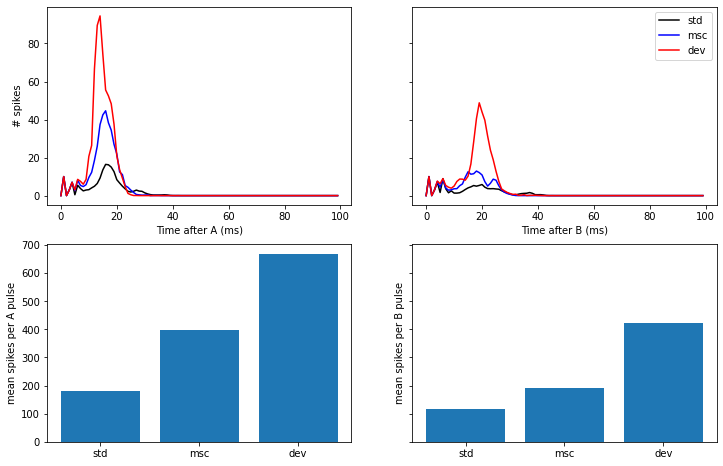

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex='row', sharey='row')
keys = ('std', 'msc', 'dev')
x = np.arange(stop=params['ISI'], step=params['dt'])/ms
for ax, stim in zip(axs[0], ('A', 'B')):
    for key, color in zip(keys, ('k', 'b', 'r')):
        ax.plot(x[:100], all_results[stim][key]['spike_hist'].sum(0)[:100], c=color, label=key)
    ax.set_xlabel(f'Time after {stim} (ms)')
axs[0,0].set_ylabel('# spikes')
axs[0,1].legend()

for ax, (target, results) in zip(axs[1], all_results.items()):
    ax.bar(keys, [results[key]['nspikes'].sum() for key in keys])
    ax.set_ylabel(f'mean spikes per {target} pulse')

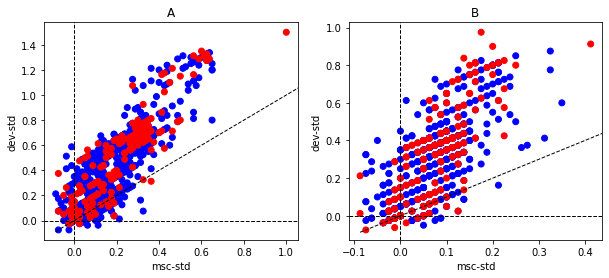

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(121)
scatter_nspikes(params, all_results['A']['Std'], all_results['B']['Std'], all_results['A']['MSC'], A)
plt.title('A')
plt.subplot(122)
scatter_nspikes(params, all_results['B']['Std'], all_results['A']['Std'], all_results['B']['MSC'], B)
plt.title('B');

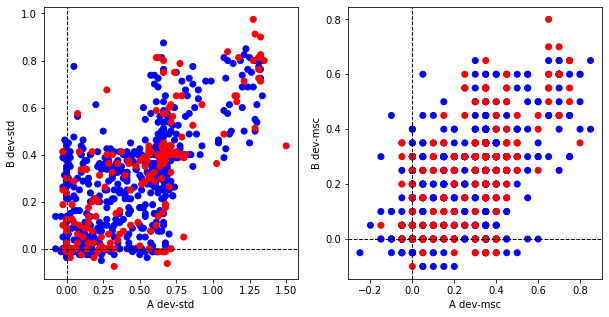

In [36]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
colors = np.where(np.arange(params['N']) < params['N_exc'], np.asarray(['b']), np.asarray(['r']))
for ax, cond in zip(axs, ('std', 'msc')):
    ax.scatter(all_results['A']['dev']['nspikes'] - all_results['A'][cond]['nspikes'], all_results['B']['dev']['nspikes'] - all_results['B'][cond]['nspikes'], c=colors)
    ax.set_xlabel(f'A dev-{cond}')
    ax.set_ylabel(f'B dev-{cond}')
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.axvline(0, c='k', ls='--', lw=1)

In [ ]:
raise InterruptedError

In [ ]:
np.savez(fname, W=W, X=X, Y=Y, D=D, A=A, B=B)
print(f'Saved structure to {fname}')

In [13]:
f = np.load(fname)
W, X, Y, D, A, B = [f[k] for k in 'WXYDAB']
X, Y = X*meter, Y*meter

In [14]:
device.reinit()
device.activate()
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params, state_dt=params['dt'], reset_dt=inputs.get_episode_duration(params))
all_results, T = readout.setup_run(Net, params, rng, {'A': A, 'B': B})
Net.run(T)

WARNING    OpenMP code is not yet well tested, and may be inaccurate. [brian2.devices.cpp_standalone.device.openmp]


In [15]:
readout.get_results(Net, params, W, all_results)

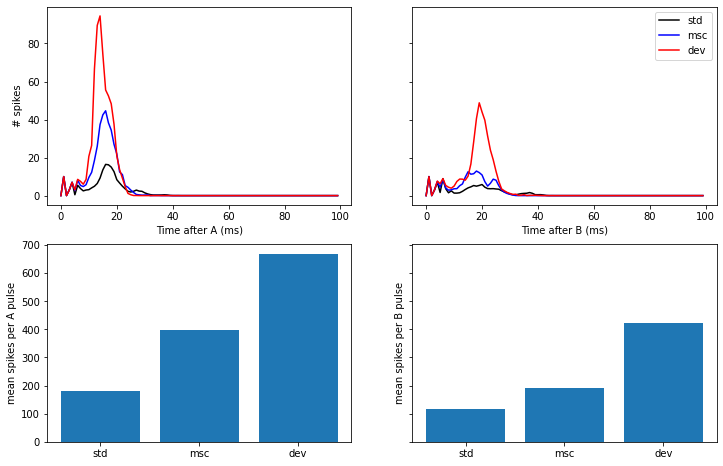

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex='row', sharey='row')
keys = ('std', 'msc', 'dev')
x = np.arange(stop=params['ISI'], step=params['dt'])/ms
for ax, stim in zip(axs[0], ('A', 'B')):
    for key, color in zip(keys, ('k', 'b', 'r')):
        ax.plot(x[:100], all_results[stim][key]['spike_hist'].sum(0)[:100], c=color, label=key)
    ax.set_xlabel(f'Time after {stim} (ms)')
axs[0,0].set_ylabel('# spikes')
axs[0,1].legend()

for ax, (target, results) in zip(axs[1], all_results.items()):
    ax.bar(keys, [results[key]['nspikes'].sum() for key in keys])
    ax.set_ylabel(f'mean spikes per {target} pulse')

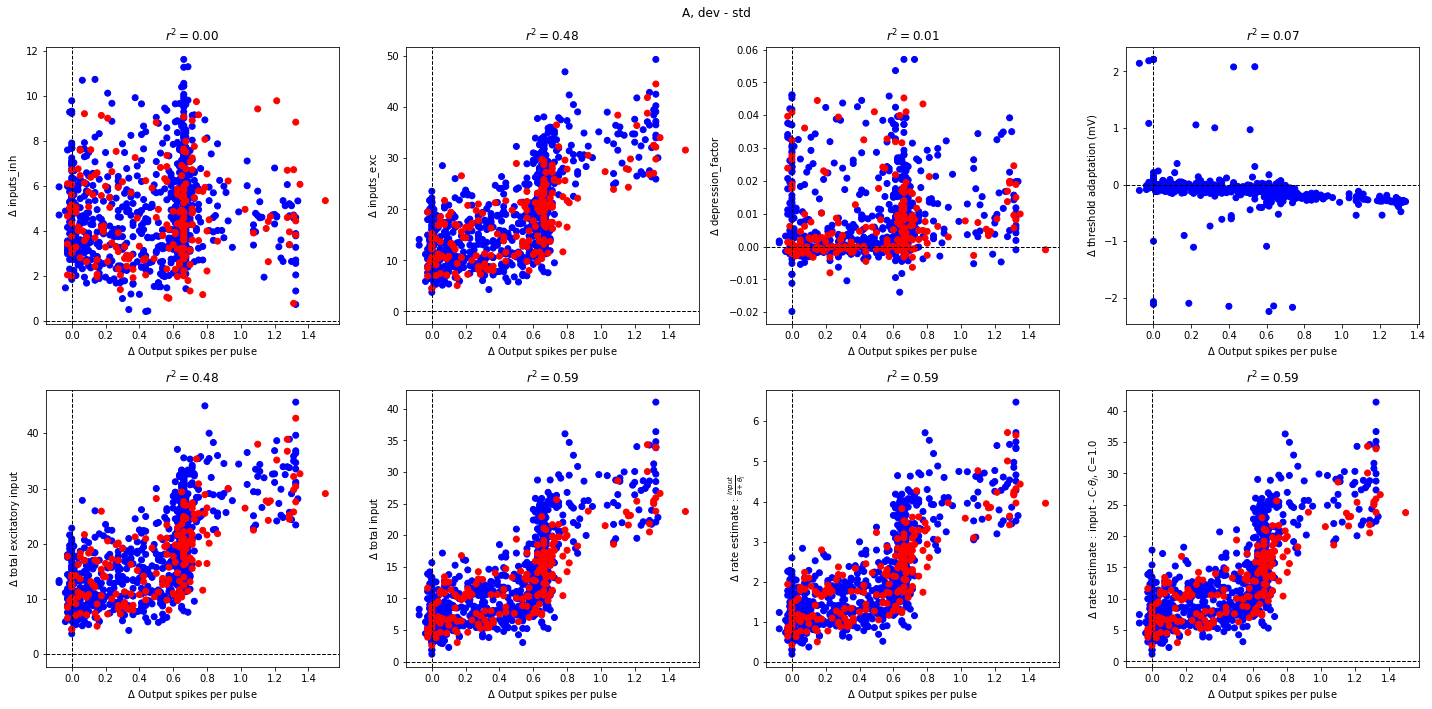

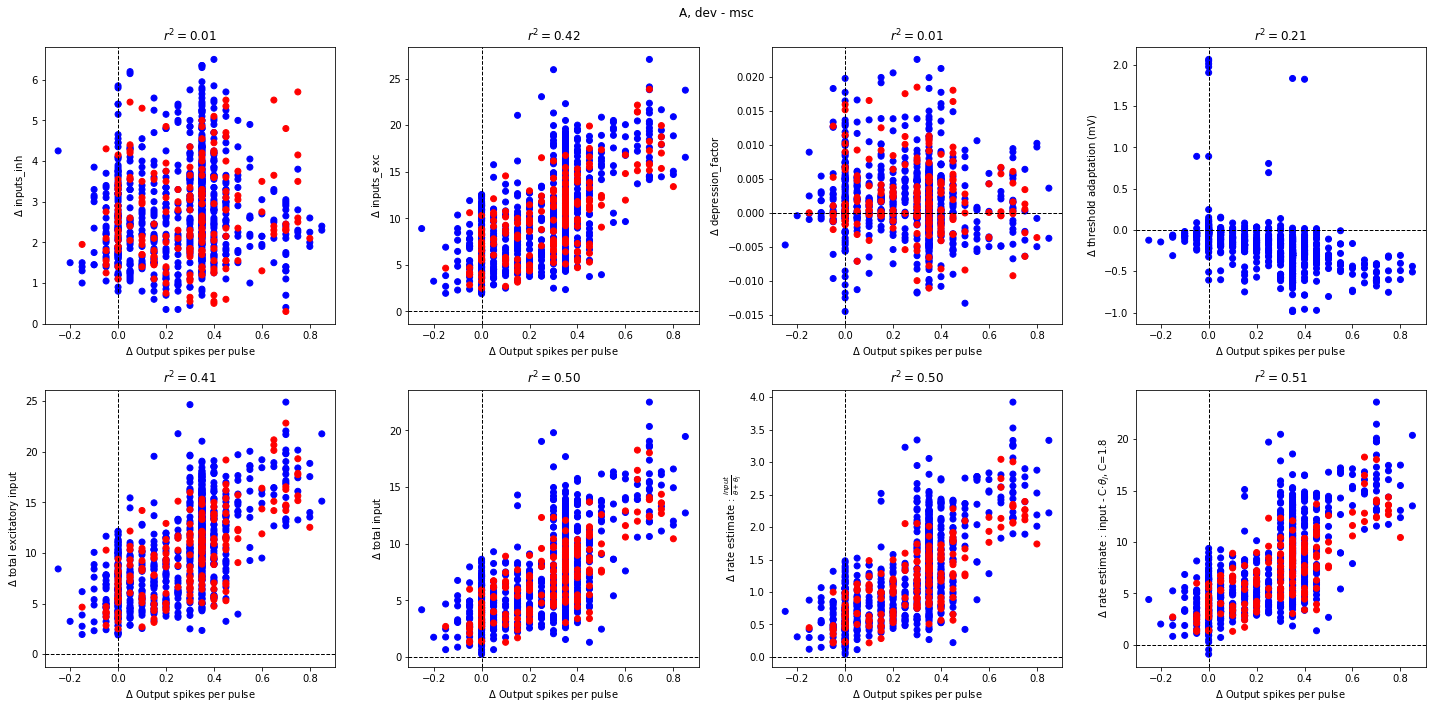

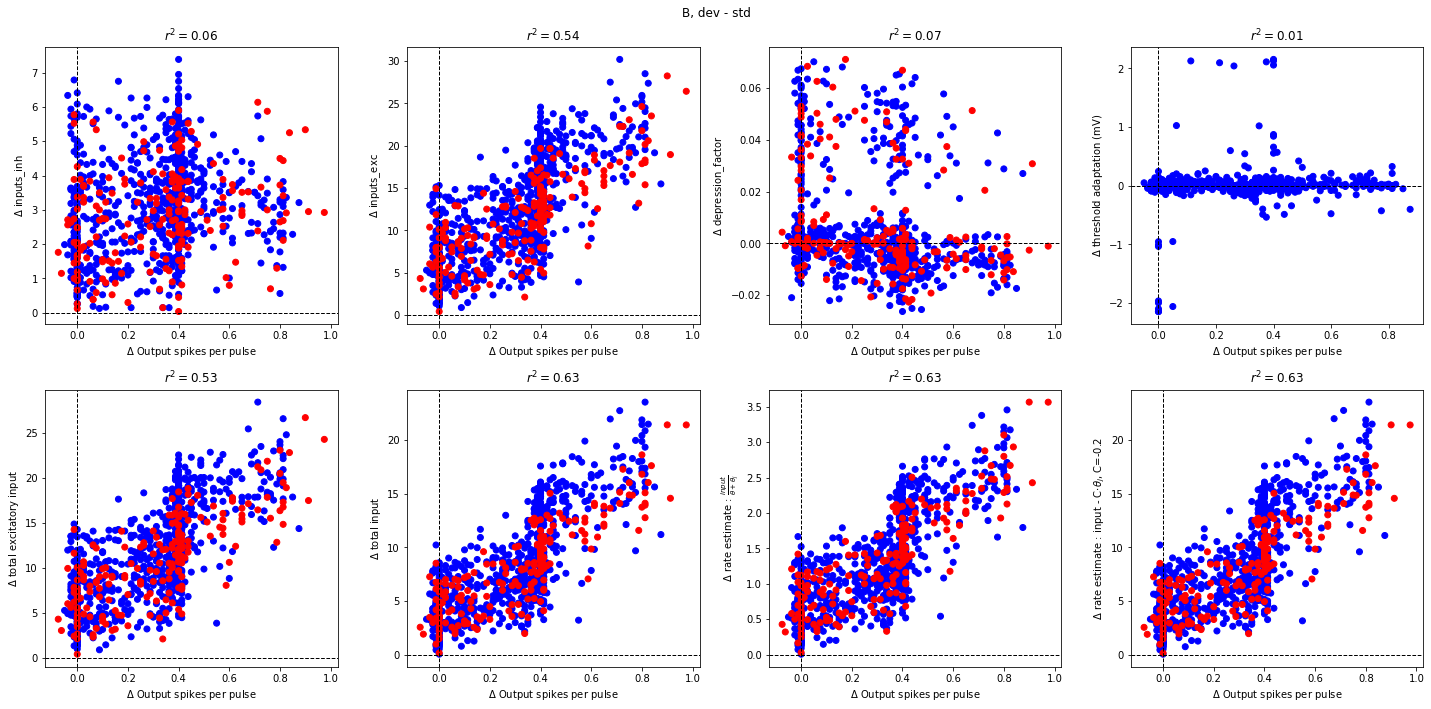

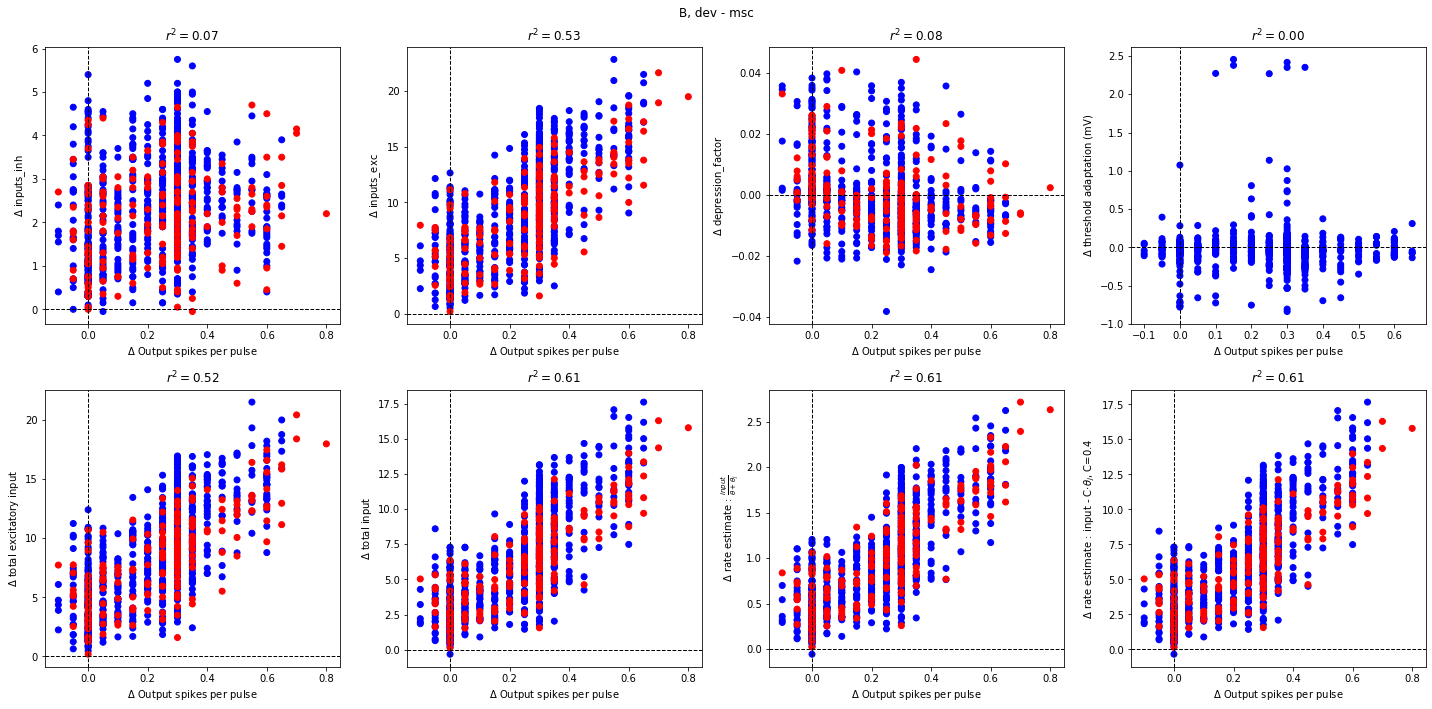

In [17]:
for target in ('A', 'B'):
    for cond2 in ('std', 'msc'):
        scatter_IO(params, all_results, target, 'dev', cond2)

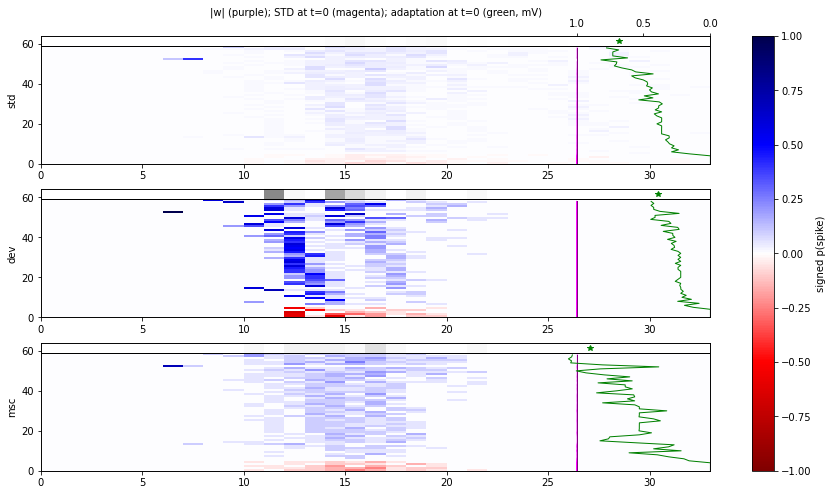

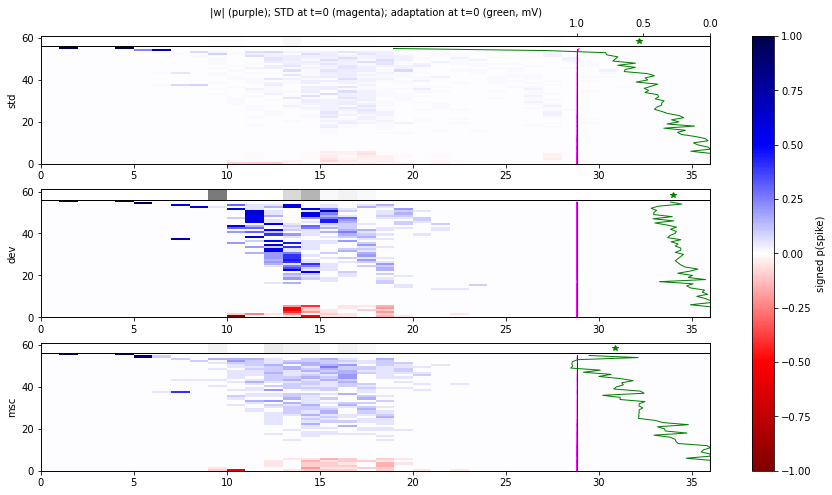

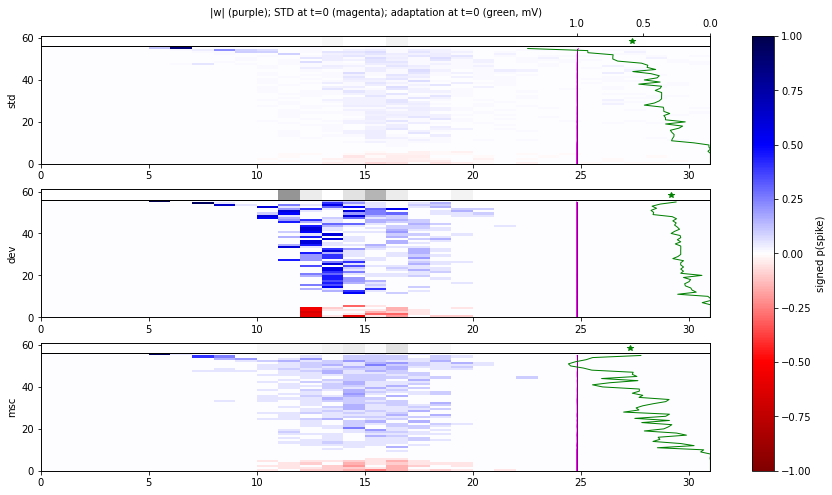

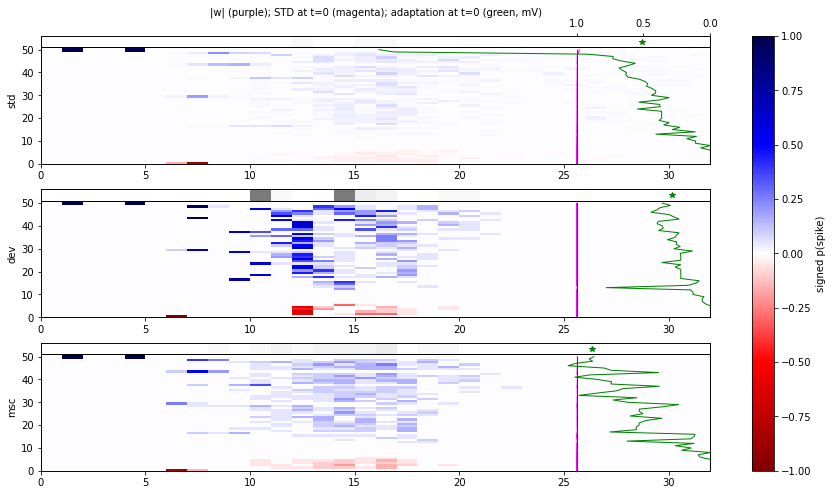

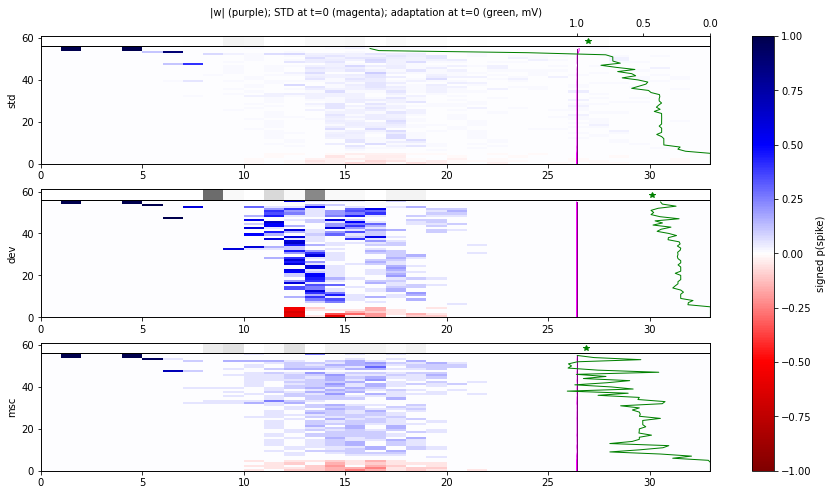

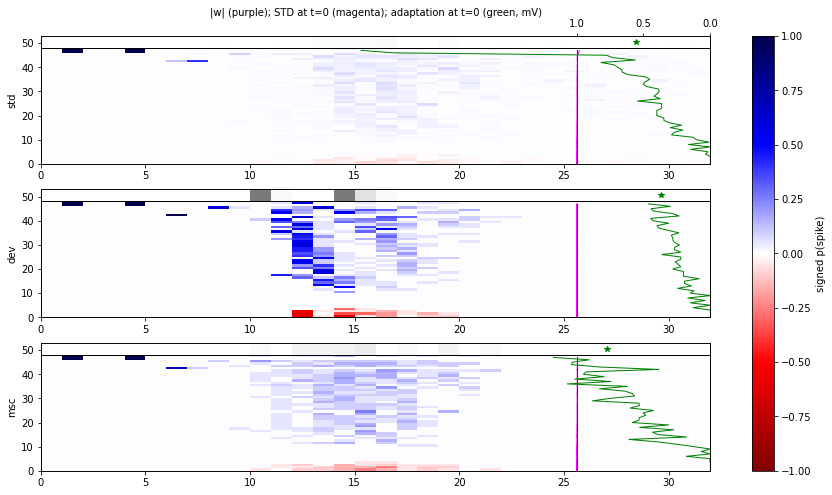

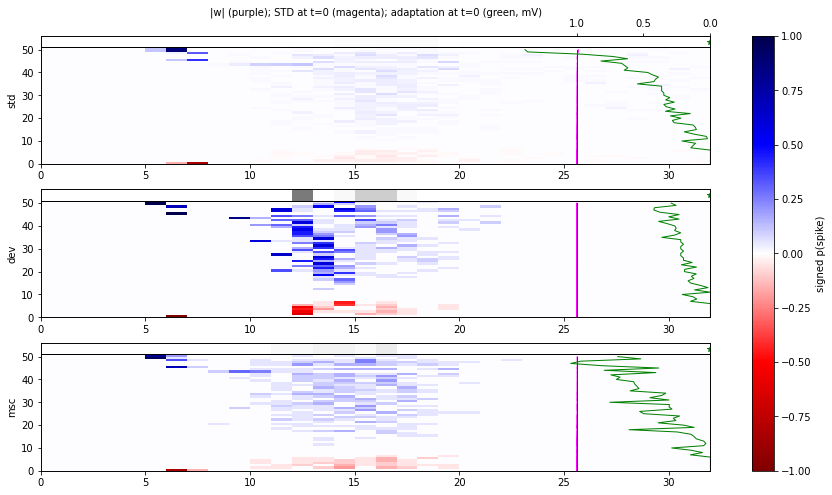

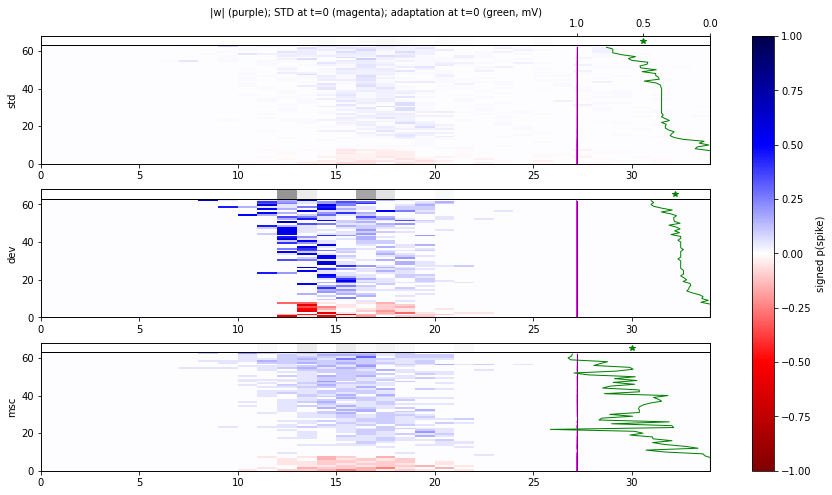

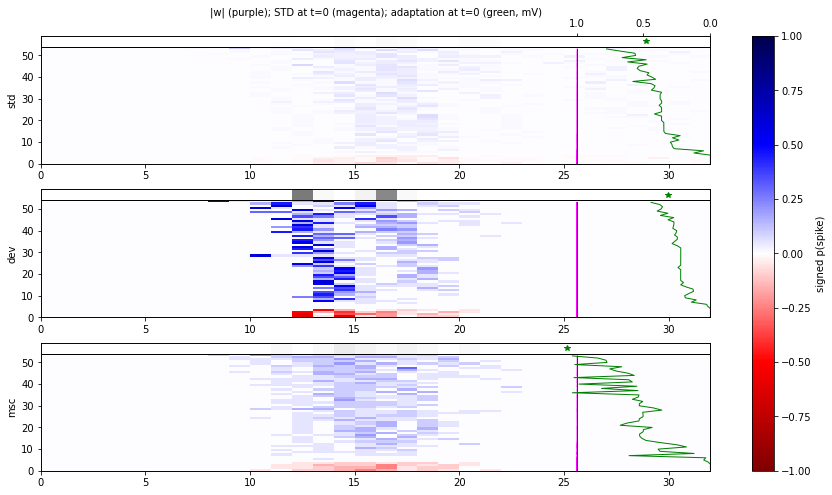

In [18]:
for i in np.argsort(all_results['A']['dev']['nspikes'] - all_results['A']['msc']['nspikes'])[-1:-10:-1]:
    plot_events(W, params, all_results['A'], i, figsize=(15,8))

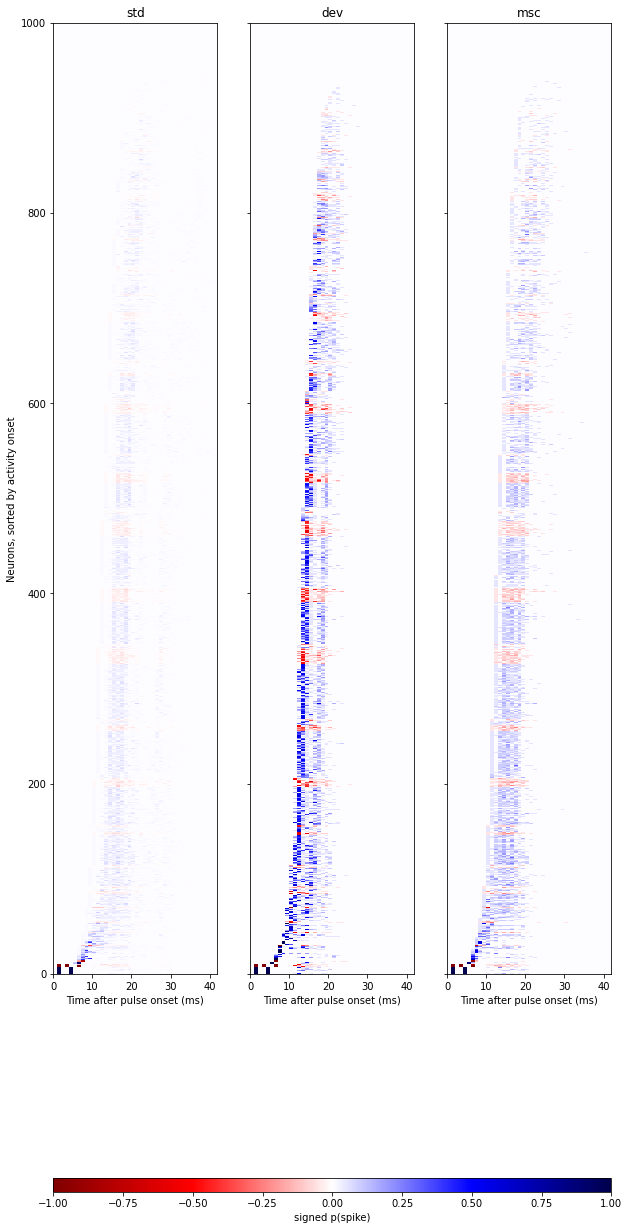

In [19]:
plot_population_spikehist(params, all_results['A'])

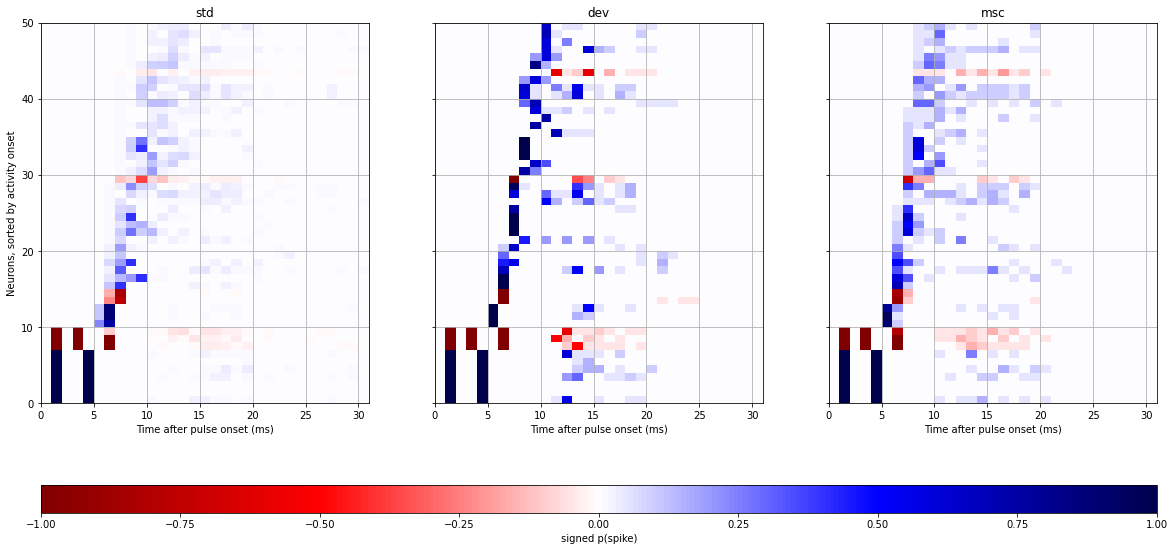

In [20]:
selection = plot_population_spikehist(params, all_results['A'], earliest=50, figsize=(20,10), grid=True, return_selection=True)

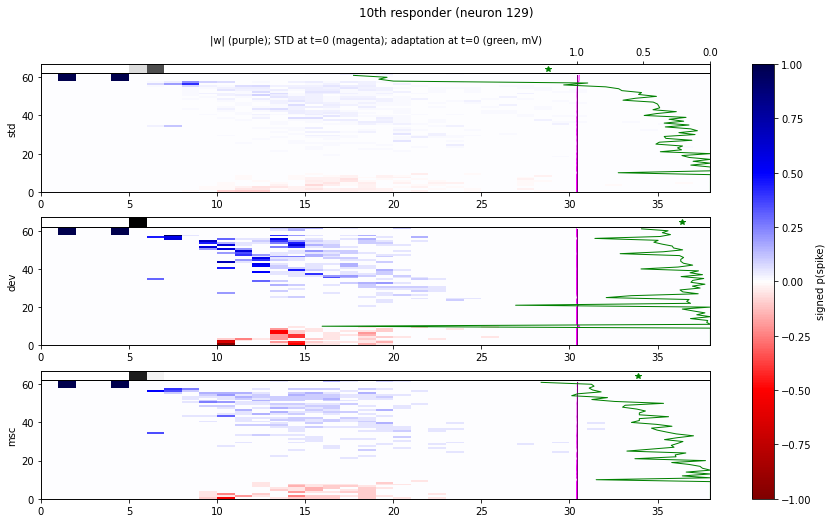

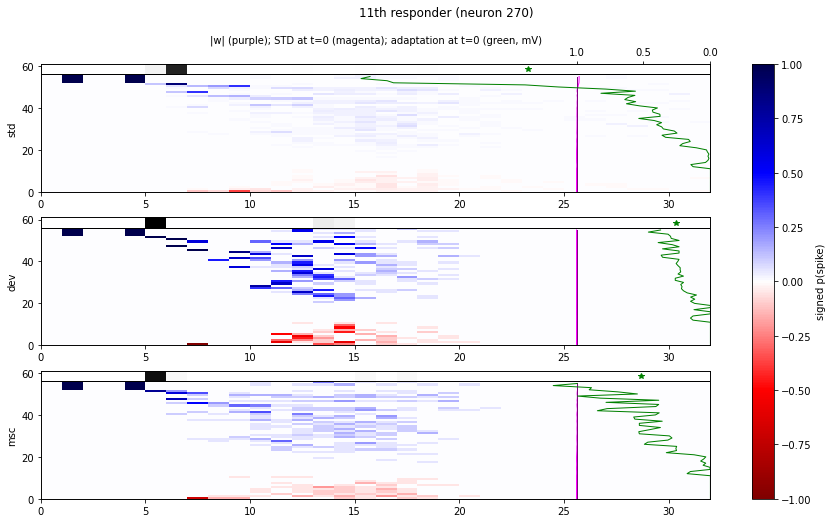

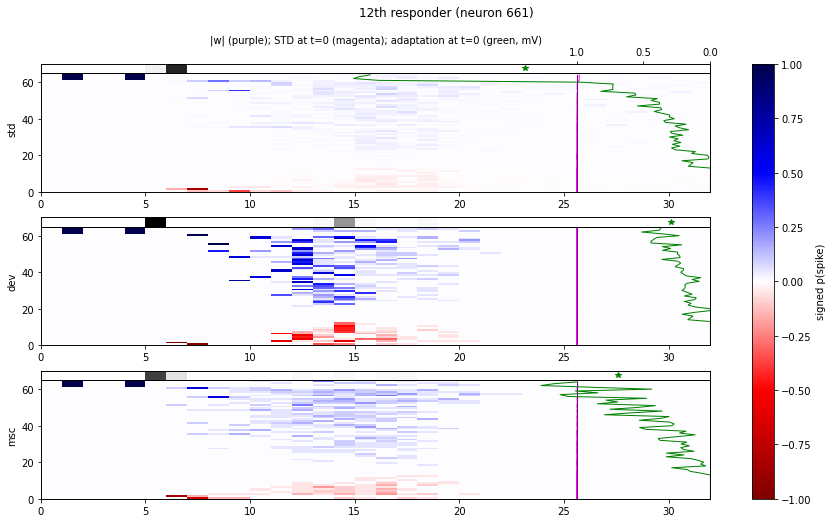

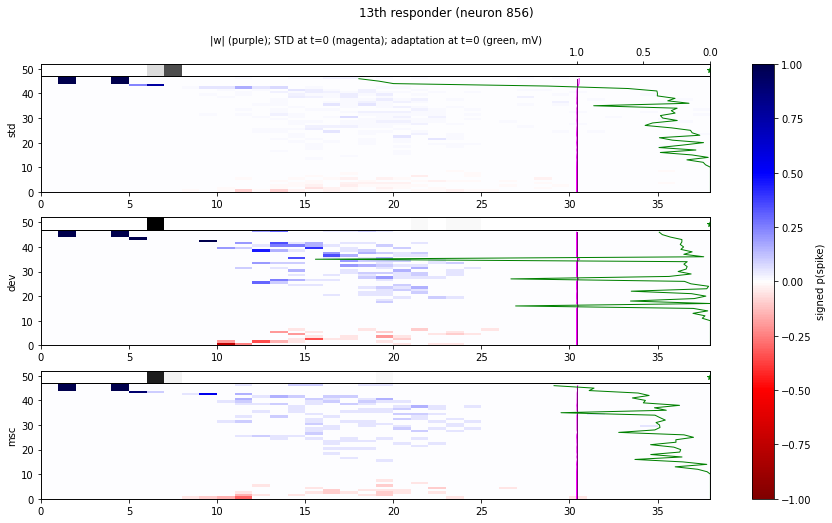

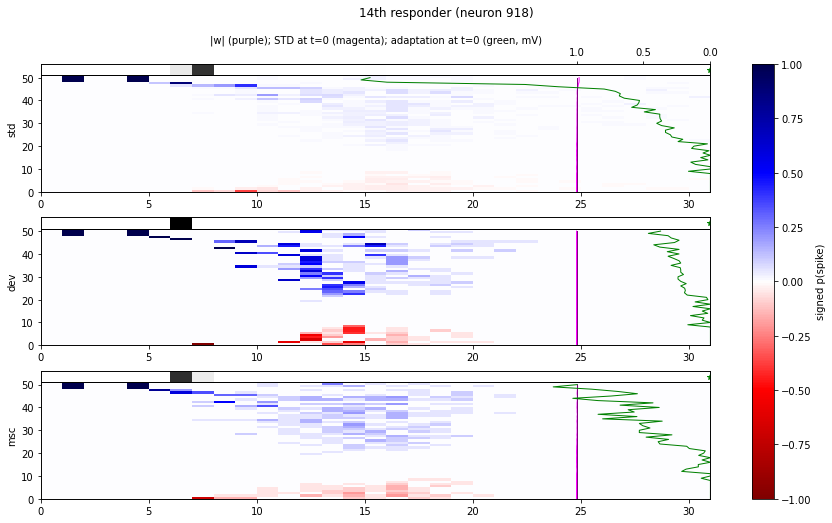

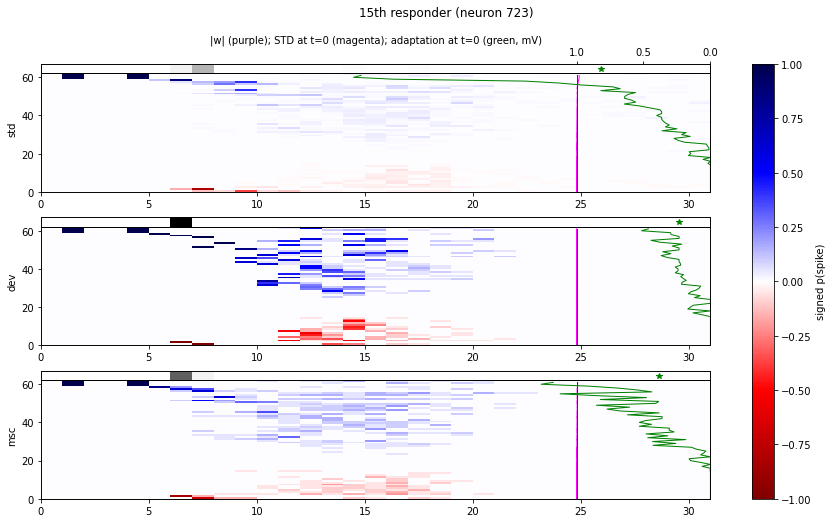

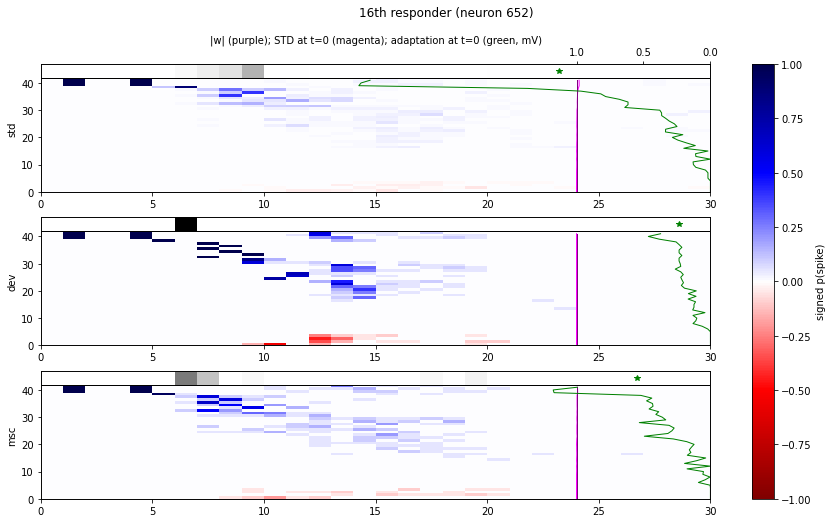

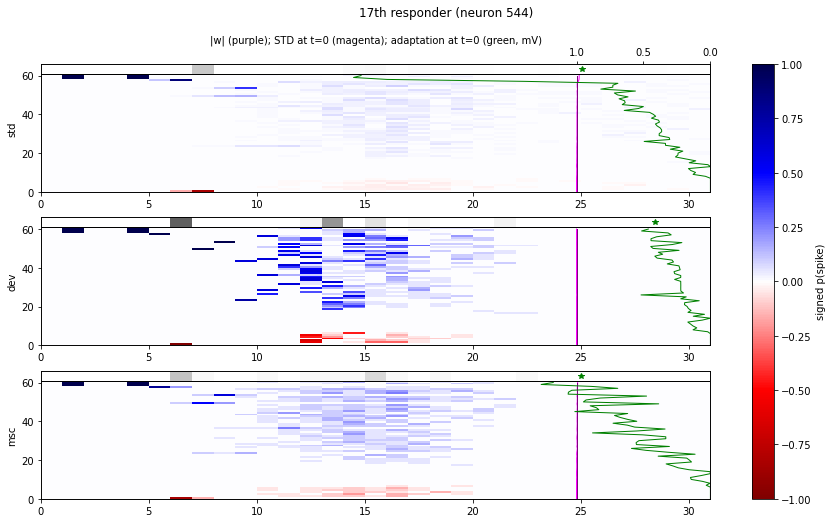

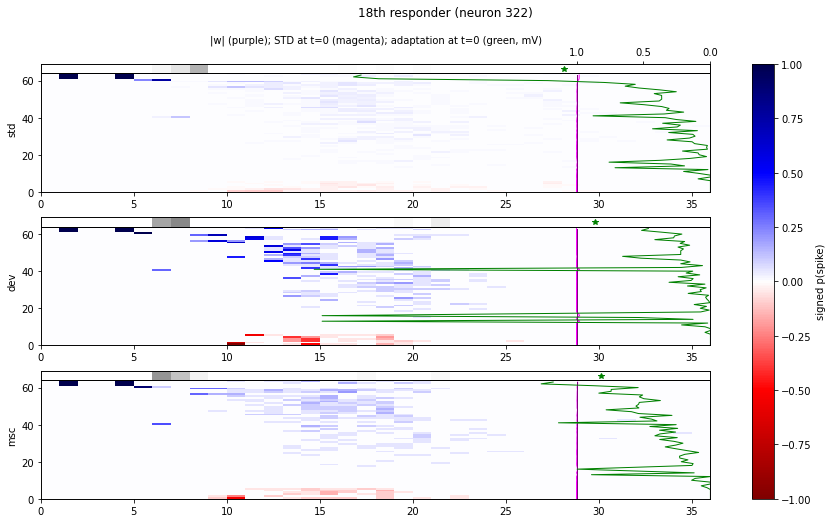

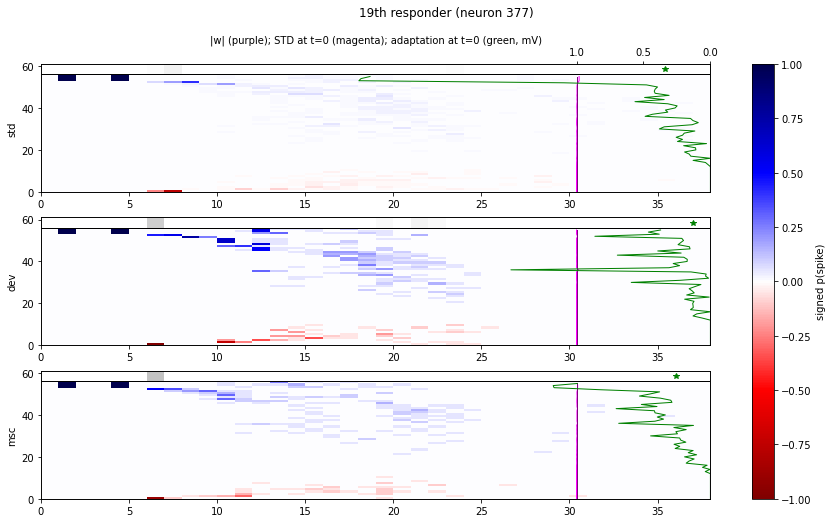

In [21]:
for j, i in enumerate(selection[10:20]):
    plot_events(W, params, all_results['A'], i, figsize=(15,8))
    plt.suptitle(f'{j+10}th responder (neuron {i})')

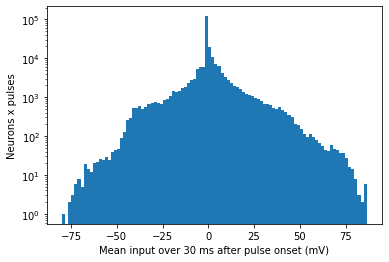

In [22]:
t_ = 30
out_ = []
for x in ('A', 'B'):
    notx = np.ones(params['N'], bool)
    notx[spatial.get_stimulated(X, Y, Xstim, Ystim, params)[all_results[x]['stimulus']]] = False
    out_.append((all_results[x]['std']['g_exc'][notx, :, :int(t_*ms/params['dt'] +.5)]*(params['E_exc']-params['v_rest'])
            + all_results[x]['std']['g_inh'][notx, :, :int(t_*ms/params['dt'] +.5)]*(params['E_inh']-params['v_rest'])
            ).mean(axis=2).flatten())
    out_.append((all_results[x]['dev']['g_exc'][notx, :, :int(t_*ms/params['dt'] +.5)]*(params['E_exc']-params['v_rest'])
            + all_results[x]['dev']['g_inh'][notx, :, :int(t_*ms/params['dt'] +.5)]*(params['E_inh']-params['v_rest'])
            ).mean(axis=2).flatten())
    out_.append((all_results[x]['msc']['g_exc'][notx, :, :int(t_*ms/params['dt'] +.5)]*(params['E_exc']-params['v_rest'])
            + all_results[x]['msc']['g_inh'][notx, :, :int(t_*ms/params['dt'] +.5)]*(params['E_inh']-params['v_rest'])
            ).mean(axis=2).flatten())
plt.hist(np.concatenate(out_)/mV, bins=100)
plt.semilogy()
plt.xlabel(f'Mean input over {t_} ms after pulse onset (mV)')
plt.ylabel('Neurons x pulses');

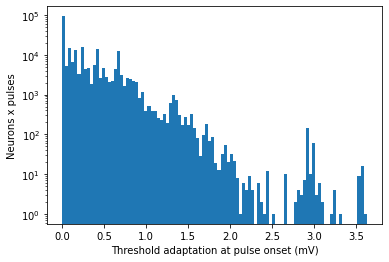

In [23]:
out_ = []
for x in ('A', 'B'):
    notx = np.ones(params['N'], bool)
    notx[spatial.get_stimulated(X, Y, Xstim, Ystim, params)[all_results[x]['stimulus']]] = False
    for key in ('std', 'dev', 'msc'):
        out_.append(all_results[x][key]['pulse_onset_th_adapt'][:, notx].flatten())
plt.hist(np.concatenate(out_) / mV, bins=100)
plt.semilogy()
plt.xlabel(f'Threshold adaptation at pulse onset (mV)')
plt.ylabel('Neurons x pulses');

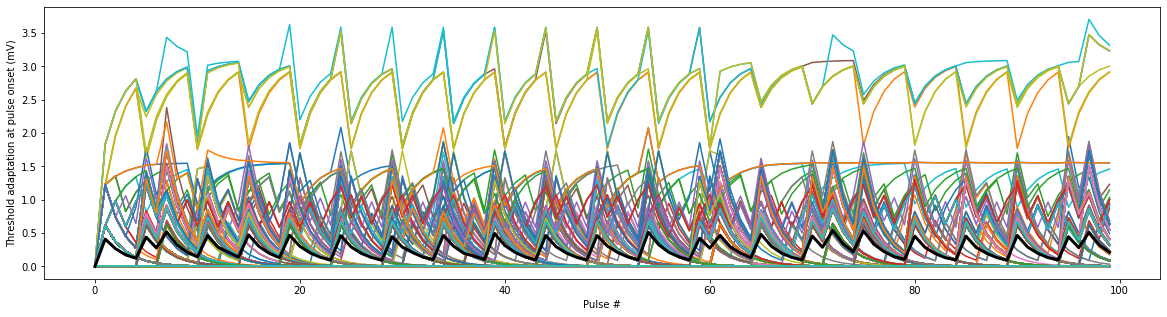

In [24]:
plt.figure(figsize=(20,5))
plt.plot(all_results['A']['Std']['th_adapt'][:,:,0].T/mV)
plt.plot(all_results['A']['Std']['th_adapt'][:,:,0].T.mean(1)/mV, lw=3, c='k')
plt.xlabel('Pulse #')
plt.ylabel('Threshold adaptation at pulse onset (mV)');

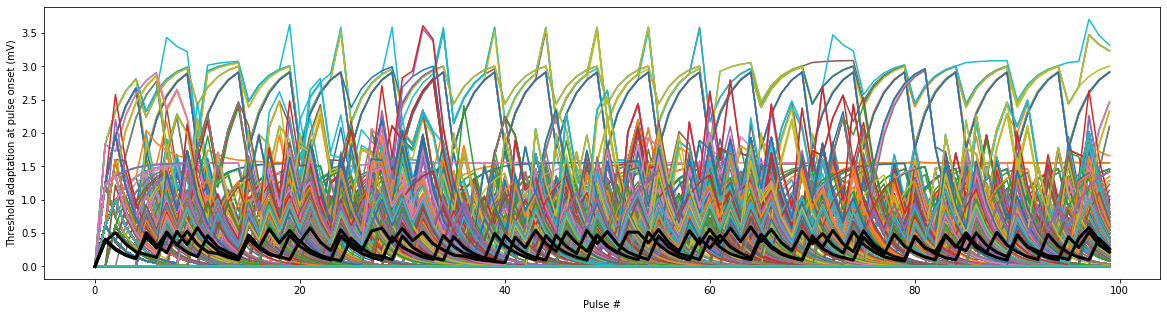

In [25]:
plt.figure(figsize=(20,5))
for key in ('Std', 'Dev', 'MSC'):
    plt.plot(all_results['A'][key]['th_adapt'][:,:,0].T/mV)
for key in ('Std', 'Dev', 'MSC'):
    plt.plot(all_results['A'][key]['th_adapt'][:,:,0].T.mean(1)/mV, lw=3, c='k')
plt.xlabel('Pulse #')
plt.ylabel('Threshold adaptation at pulse onset (mV)');

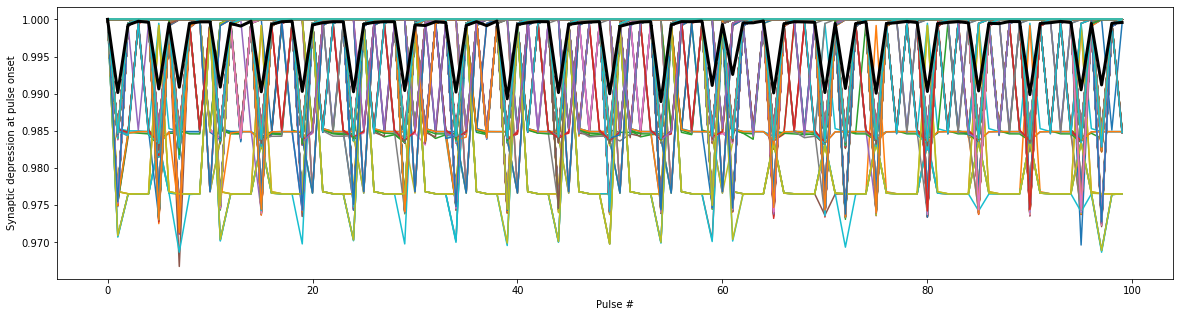

In [26]:
plt.figure(figsize=(20,5))
plt.plot(all_results['A']['Std']['xr'][:,:,0].T)
plt.plot(all_results['A']['Std']['xr'][:,:,0].T.mean(1), lw=3, c='k')
plt.xlabel('Pulse #')
plt.ylabel('Synaptic depression at pulse onset');

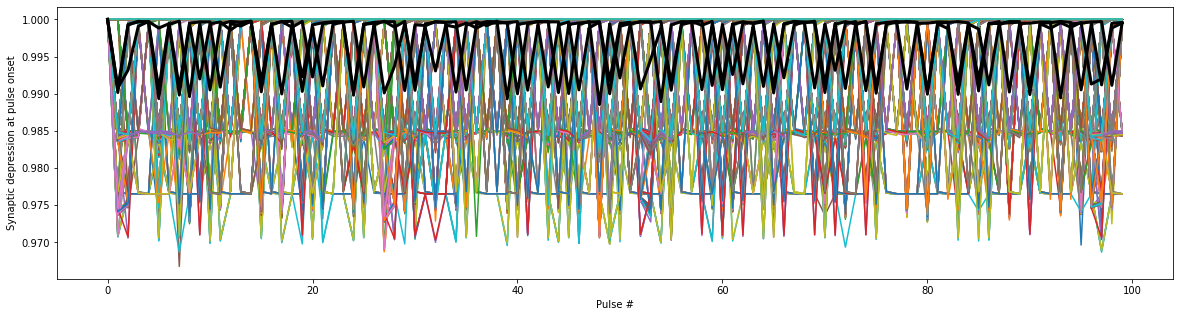

In [27]:
plt.figure(figsize=(20,5))
for key in ('Std', 'Dev', 'MSC'):
    plt.plot(all_results['A'][key]['xr'][:,:,0].T)
for key in ('Std', 'Dev', 'MSC'):
    plt.plot(all_results['A'][key]['xr'][:,:,0].T.mean(1), lw=3, c='k')
plt.xlabel('Pulse #')
plt.ylabel('Synaptic depression at pulse onset');

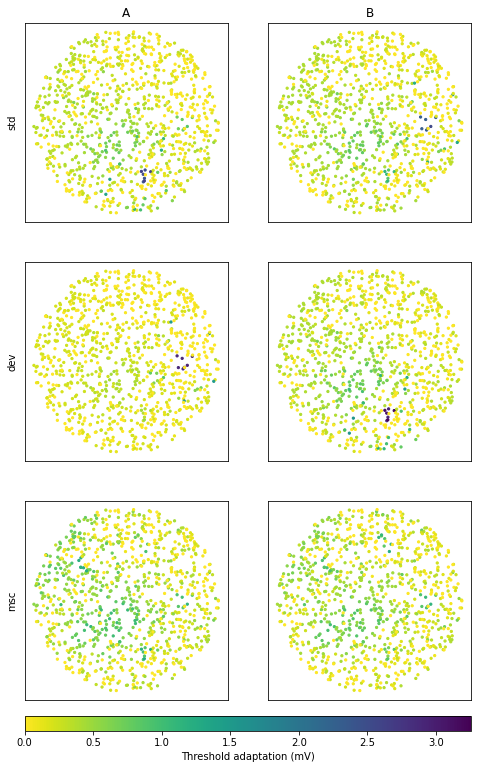

In [28]:
vmax = 0
for x in ('A', 'B'):
    for key in ('std', 'dev', 'msc'):
        vmax = max(vmax, all_results[x][key]['pulse_onset_th_adapt'].mean(0).max()/mV)

cm = plt.get_cmap('viridis_r')
cNorm  = mpl_colors.Normalize(vmin=0, vmax=vmax)
scalarMap = mpl_cm.ScalarMappable(norm=cNorm, cmap=cm)

fig, axgrid = plt.subplots(3, 2, figsize=(8,15))
for axs, key in zip(axgrid, ('std', 'dev', 'msc')):
    for ax, x in zip(axs, ('A', 'B')):
        ax.scatter(X, Y, c=scalarMap.to_rgba(all_results[x][key]['pulse_onset_th_adapt'].mean(0)/mV), s=5)
        ax.set_xticks([])
        ax.set_yticks([])
        if key=='std':
            ax.set_title(x)
    axs[0].set_ylabel(key)
plt.colorbar(scalarMap, location='bottom', ax=axgrid, aspect=30, label='Threshold adaptation (mV)', pad=.02)

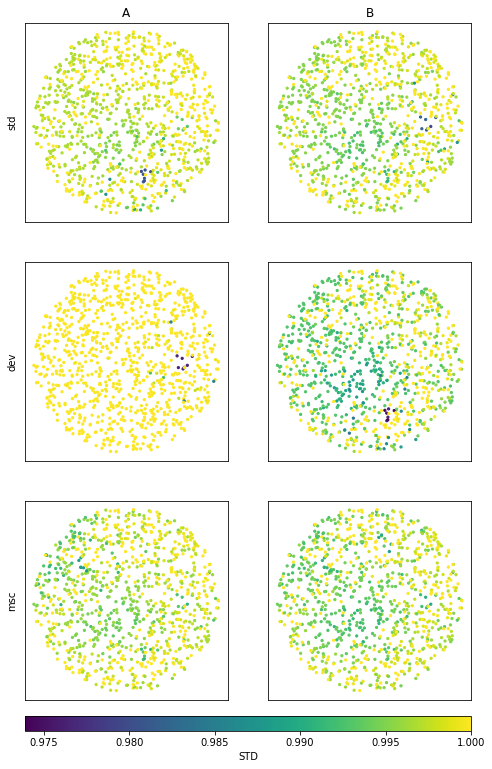

In [29]:
vmin = 1
for x in ('A', 'B'):
    for key in ('std', 'dev', 'msc'):
        vmin = min(vmin, all_results[x][key]['pulse_onset_xr'].mean(0).min())

cm = plt.get_cmap('viridis')
cNorm  = mpl_colors.Normalize(vmin=vmin, vmax=1)
scalarMap = mpl_cm.ScalarMappable(norm=cNorm, cmap=cm)

fig, axgrid = plt.subplots(3, 2, figsize=(8,15))
for axs, key in zip(axgrid, ('std', 'dev', 'msc')):
    for ax, x in zip(axs, ('A', 'B')):
        ax.scatter(X, Y, c=scalarMap.to_rgba(all_results[x][key]['pulse_onset_xr'].mean(0)), s=5)
        ax.set_xticks([])
        ax.set_yticks([])
        if key=='std':
            ax.set_title(x)
    axs[0].set_ylabel(key)
plt.colorbar(scalarMap, location='bottom', ax=axgrid, aspect=30, label='STD', pad=.02)

In [30]:
figsize=(5,10)

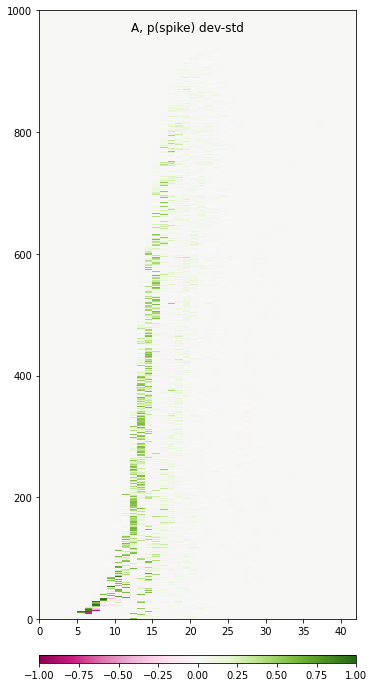

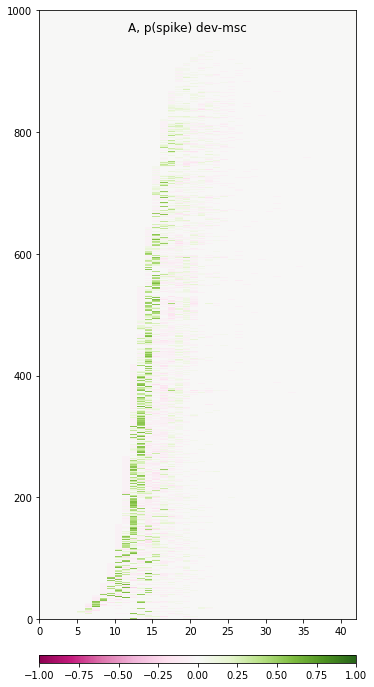

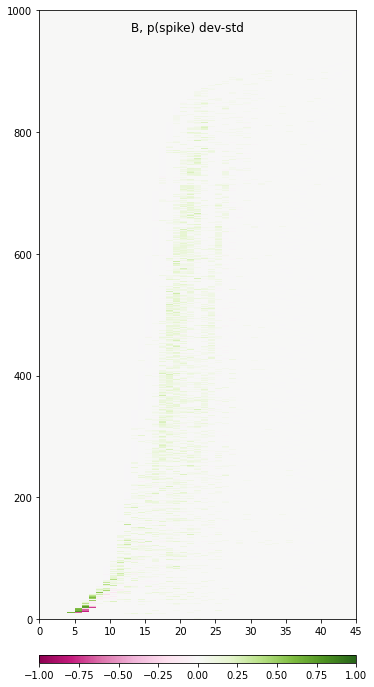

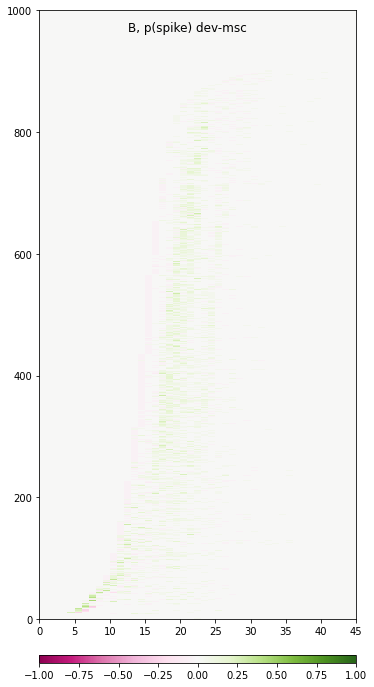

In [31]:
for identity in ['A', 'B']:
    for contrast in ('std', 'msc'):
        plot_population_time_contrast(params, all_results[identity], 'dev', contrast, 'spike_hist', figsize=figsize, vmax=1)
        plt.suptitle(f'{identity}, p(spike) dev-{contrast}')

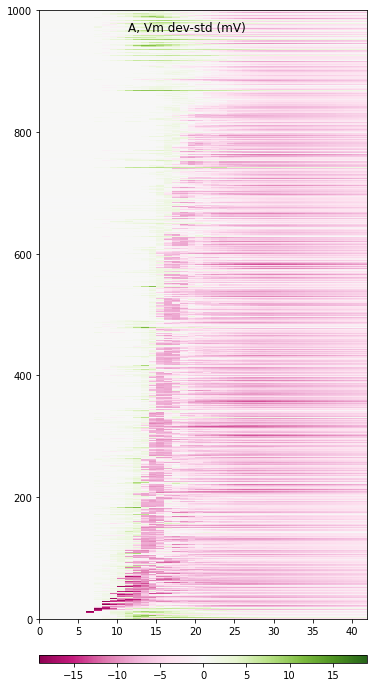

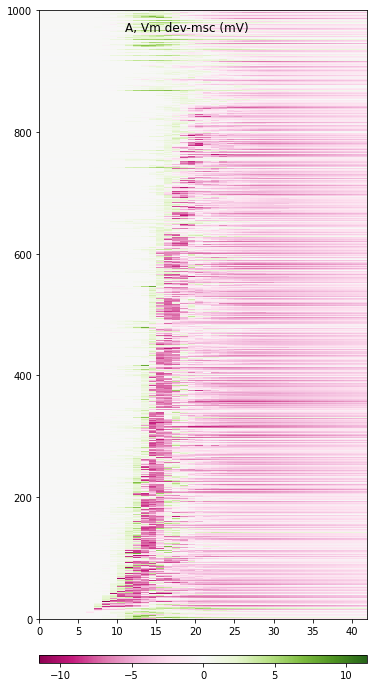

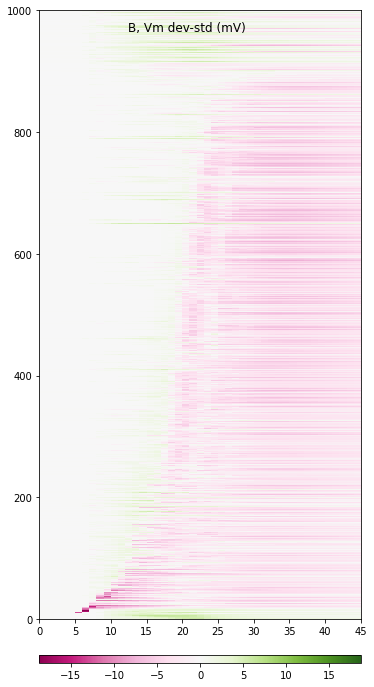

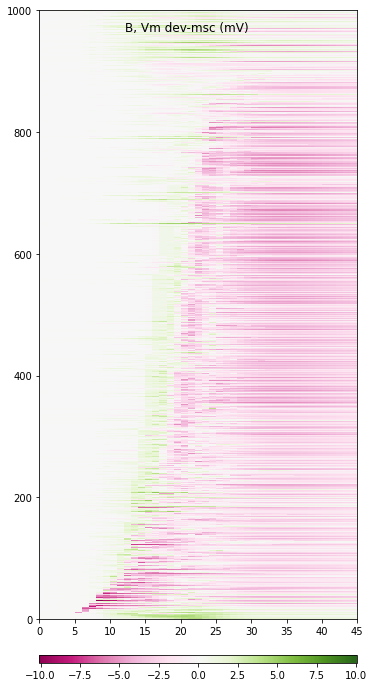

In [32]:
for identity in ['A', 'B']:
    for contrast in ('std', 'msc'):
        plot_population_time_contrast(params, all_results[identity], 'dev', contrast, 'v', mV, figsize=figsize)
        plt.suptitle(f'{identity}, Vm dev-{contrast} (mV)')

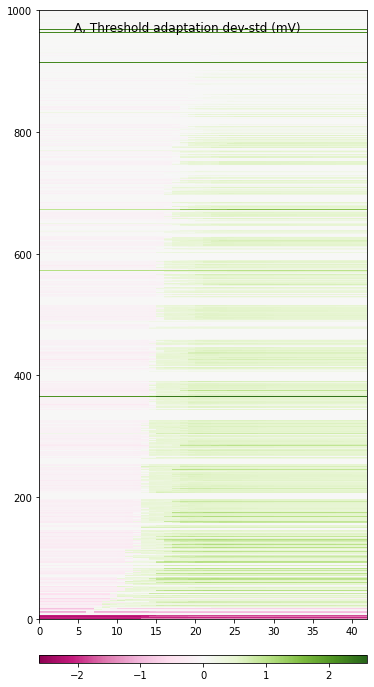

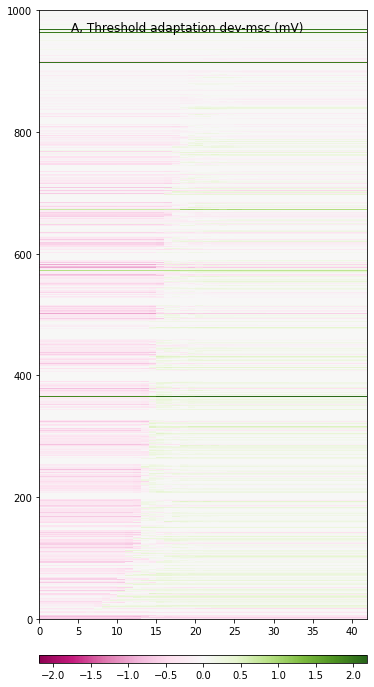

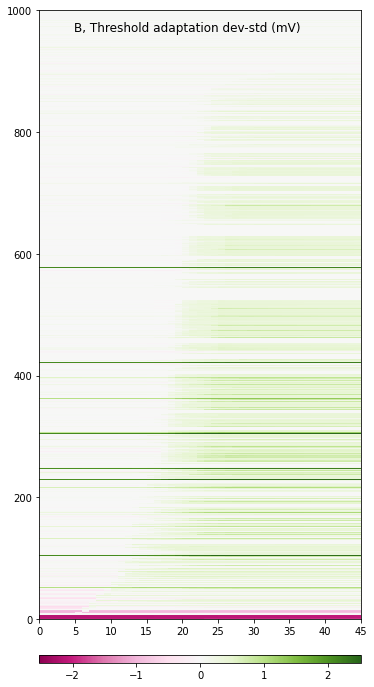

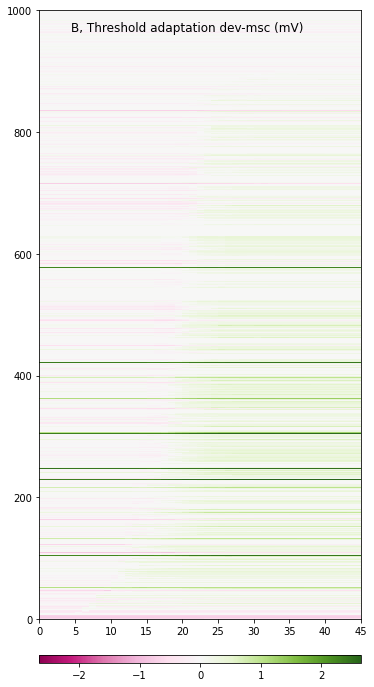

In [33]:
for identity in ['A', 'B']:
    for contrast in ('std', 'msc'):
        plot_population_time_contrast(params, all_results[identity], 'dev', contrast, 'th_adapt', mV, figsize=figsize)
        plt.suptitle(f'{identity}, Threshold adaptation dev-{contrast} (mV)')